In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
 
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen
 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
 
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

In [29]:
photoswitches = pd.read_csv('./photoswitches.csv')  # Load the photoswitch dataset using pandas
smiles_list = pd.DataFrame(photoswitches['SMILES'].to_list()) # 转化成列表数据,用ASCII字符串明确描述分子结构的规范
smiles_list

,0
0,C[N]1N=NC(=N1)N=NC2=CC=CC=C2
1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2
2,C[N]1C=CC(=N1)N=NC2=CC=CC=C2
3,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2
4,C[N]1C=C(C=N1)N=NC2=CC=CC=C2
...,...
400,OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...
401,OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...
402,N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...
403,N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...


In [3]:
for i in photoswitches.index:
    mol=Chem.MolFromSmiles(photoswitches.loc[i,'SMILES'])
    photoswitches.loc[i,'MolWt']=Descriptors.ExactMolWt (mol)
    photoswitches.loc[i,'TPSA']=Chem.rdMolDescriptors.CalcTPSA(mol) #Topological Polar Surface Area
    photoswitches.loc[i,'nRotB']=Descriptors.NumRotatableBonds (mol) #Number of rotable bonds
    photoswitches.loc[i,'HBD']=Descriptors.NumHDonors(mol) #Number of H bond donors
    photoswitches.loc[i,'HBA']=Descriptors.NumHAcceptors(mol) #Number of H bond acceptors
    photoswitches.loc[i,'LogP']=Descriptors.MolLogP(mol) #LogP

In [4]:
descriptors = photoswitches.loc[:, ['MolWt', 'TPSA', 'nRotB', 'HBD','HBA', 'LogP']].values

In [5]:
descriptors_std = StandardScaler().fit_transform(descriptors)

In [6]:
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)

descriptors_pca= pd.DataFrame(descriptors_2d)
descriptors_pca.index = photoswitches.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(10)


,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.292014,-2.453941,-2.505376,0.477925,0.832529,0.072638
1,-1.715138,-1.777637,-1.944894,0.246319,0.623260,0.037738
2,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839
3,-1.980135,-0.787001,-1.182908,0.101213,0.370877,-0.003917
4,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839
5,-1.822007,-0.472669,-0.981403,0.187714,0.327762,-0.010672
6,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839
7,-1.980135,-0.787001,-1.182908,0.101213,0.370877,-0.003917
8,-2.245131,0.203635,-0.420921,-0.043892,0.118493,-0.045572
9,-2.087003,0.517967,-0.219416,0.042608,0.075379,-0.052327


In [8]:
print(pca.explained_variance_ratio_) 
print(sum(pca.explained_variance_ratio_))

[0.51069501 0.27805009 0.10478927 0.07216309 0.02066419 0.01363836]
1.0


<Figure size 288x216 with 0 Axes>

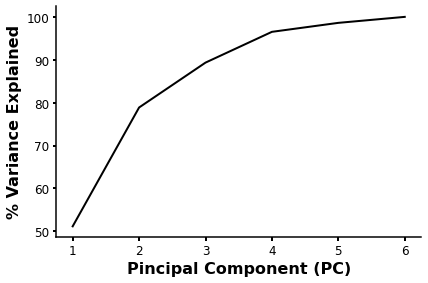

In [9]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(4,3))
fig, ax = plt.subplots(figsize=(6,4))
 
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.plot([i+1 for i in range(len(var))],var,'k-',linewidth=2)
plt.xticks([i+1 for i in range(len(var))])
plt.ylabel('% Variance Explained',fontsize=16,fontweight='bold')
plt.xlabel('Pincipal Component (PC)',fontsize=16,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.tick_params ('both',width=2,labelsize=12)

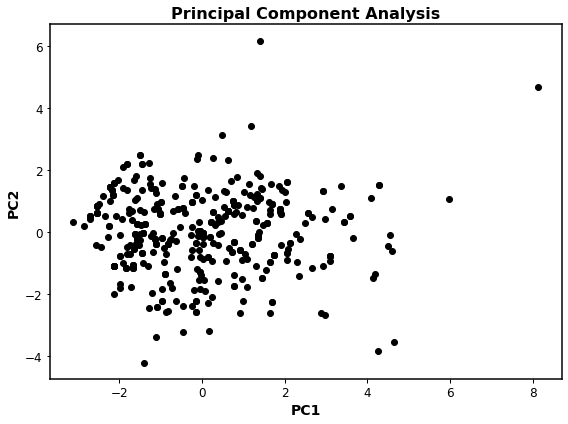

In [20]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
 
ax.plot(descriptors_pca['PC1'],descriptors_pca['PC2'],'o',color='k')
ax.set_title ('Principal Component Analysis',fontsize=16,fontweight='bold',family='sans-serif')
ax.set_xlabel ('PC1',fontsize=14,fontweight='bold')
ax.set_ylabel ('PC2',fontsize=14,fontweight='bold')
 
plt.tick_params ('both',width=1,labelsize=12)
 
plt.tight_layout()
plt.show()

In [11]:
# This normalization will be performed just for PC1 and PC2, but can be done for all the components.
scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1']))
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))
 
# add the new values to our PCA coloum
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]

In [12]:
descriptors_pca.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC1_normalized,PC2_normalized
0,-1.292014,-2.453941,-2.505376,0.477925,0.832529,0.072638,-0.114812,-0.236015
1,-1.715138,-1.777637,-1.944894,0.246319,0.623260,0.037738,-0.152413,-0.170970
2,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839,-0.190013,-0.105924
3,-1.980135,-0.787001,-1.182908,0.101213,0.370877,-0.003917,-0.175961,-0.075692
4,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839,-0.190013,-0.105924
5,-1.822007,-0.472669,-0.981403,0.187714,0.327762,-0.010672,-0.161909,-0.045460
6,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839,-0.190013,-0.105924
7,-1.980135,-0.787001,-1.182908,0.101213,0.370877,-0.003917,-0.175961,-0.075692
8,-2.245131,0.203635,-0.420921,-0.043892,0.118493,-0.045572,-0.199509,0.019585
9,-2.087003,0.517967,-0.219416,0.042608,0.075379,-0.052327,-0.185458,0.049817


For n_clusters = 2 The average silhouette_score is : 0.3913285010455547
For n_clusters = 3 The average silhouette_score is : 0.3531421484646048
For n_clusters = 4 The average silhouette_score is : 0.35610848990703026
For n_clusters = 5 The average silhouette_score is : 0.3511937429463762
For n_clusters = 6 The average silhouette_score is : 0.35948794338397416
For n_clusters = 7 The average silhouette_score is : 0.37430135260133535
For n_clusters = 8 The average silhouette_score is : 0.377021180165046
For n_clusters = 9 The average silhouette_score is : 0.38684821750198667
For n_clusters = 10 The average silhouette_score is : 0.37570477875111613


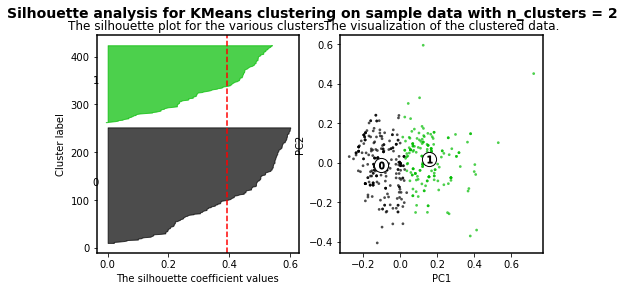

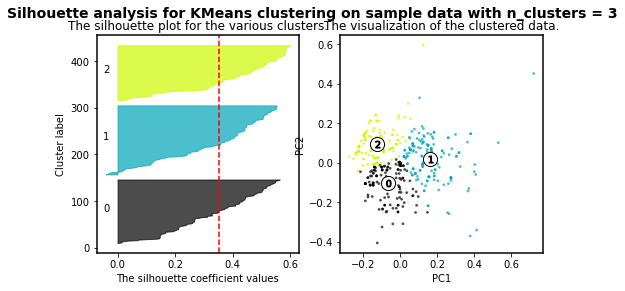

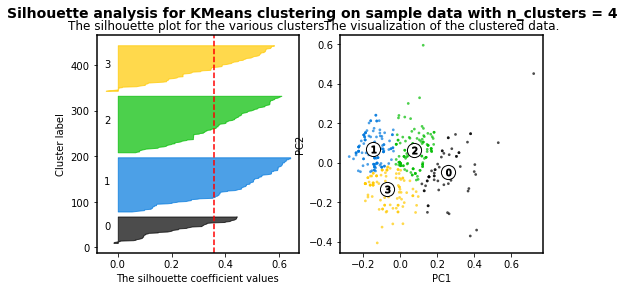

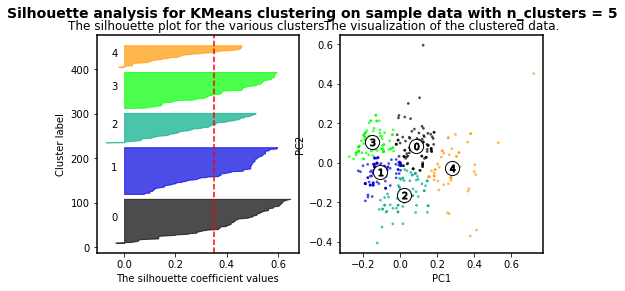

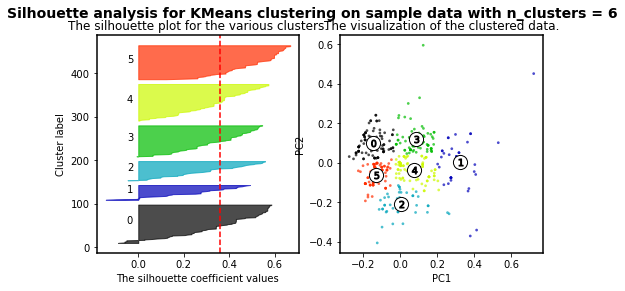

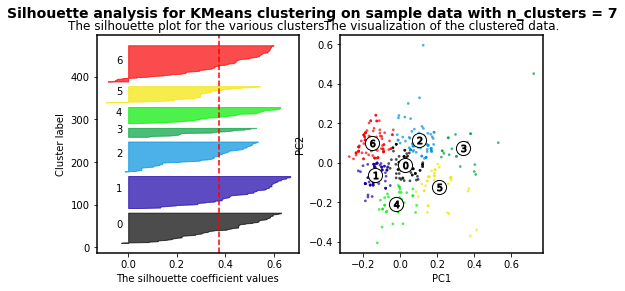

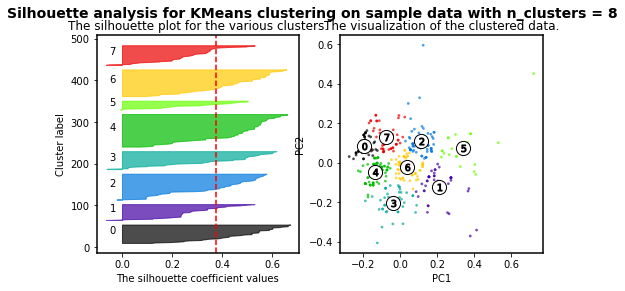

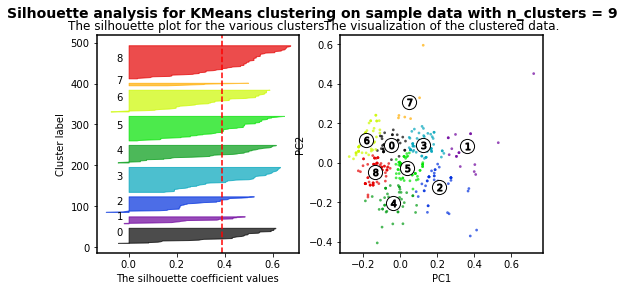

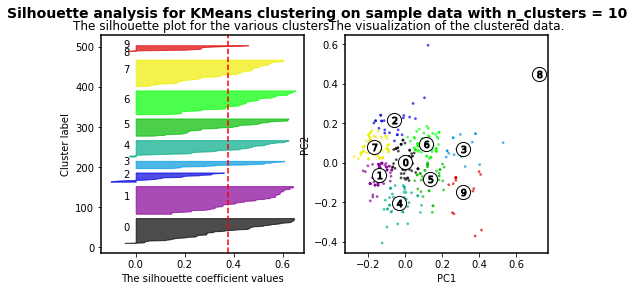

In [14]:
range_n_clusters = [2, 3, 4, 5, 6, 7,8,9,10]
for n_clusters in range_n_clusters:
    fig, (ax1,ax2)= plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(descriptors_pca[['PC1_normalized','PC2_normalized']])
    silhouette_avg = silhouette_score(descriptors_pca[['PC1_normalized','PC2_normalized']], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(descriptors_pca[['PC1_normalized','PC2_normalized']], cluster_labels)
 
    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
 
        ith_cluster_silhouette_values.sort()
 
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
 
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
 
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
 
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
 
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
 
 
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'], 
                marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')
 
 
    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
 
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
 
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
 
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
 
    
plt.show()

In [15]:
kmeans = KMeans(n_clusters=2, random_state=10) # We define the best number of clusters
clusters = kmeans.fit(descriptors_pca[['PC1_normalized','PC2_normalized']]) #PC1 vs PC2 (normalized values)

In [17]:
descriptors_pca['Cluster_PC1_PC2'] = pd.Series(clusters.labels_, index=photoswitches.index)
descriptors_pca.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC1_normalized,PC2_normalized,Cluster_PC1_PC2
0,-1.292014,-2.453941,-2.505376,0.477925,0.832529,0.072638,-0.114812,-0.236015,0
1,-1.715138,-1.777637,-1.944894,0.246319,0.623260,0.037738,-0.152413,-0.170970,0
2,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839,-0.190013,-0.105924,0
3,-1.980135,-0.787001,-1.182908,0.101213,0.370877,-0.003917,-0.175961,-0.075692,0
4,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839,-0.190013,-0.105924,0
5,-1.822007,-0.472669,-0.981403,0.187714,0.327762,-0.010672,-0.161909,-0.045460,0
6,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839,-0.190013,-0.105924,0
7,-1.980135,-0.787001,-1.182908,0.101213,0.370877,-0.003917,-0.175961,-0.075692,0
8,-2.245131,0.203635,-0.420921,-0.043892,0.118493,-0.045572,-0.199509,0.019585,0
9,-2.087003,0.517967,-0.219416,0.042608,0.075379,-0.052327,-0.185458,0.049817,0


<Figure size 720x576 with 0 Axes>

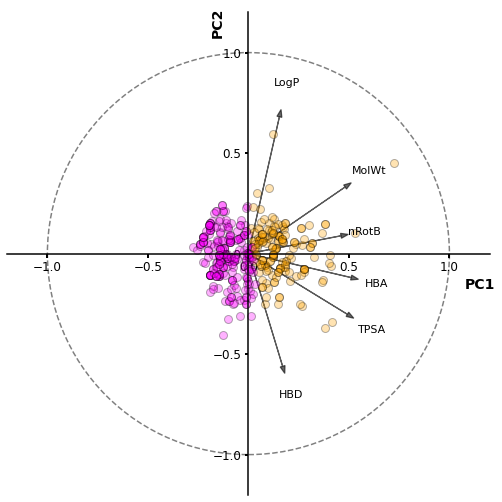

In [18]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(10,8))
 
fig, ax = plt.subplots(figsize=(7,7))
 
color_code={ 0:        'magenta',\
             1.0:   'orange',\
             2.0:      'cyan',\
             3.0:           'c',\
             4.0:        'm',\
             5.0:        'y',\
             6.0:        'darkorange',
             7.0:       'k',
             }
 
for i in descriptors_pca.index: 
        ax.plot(descriptors_pca.loc[i].at['PC1_normalized'],descriptors_pca.loc[i].at['PC2_normalized'],
                    c=color_code[descriptors_pca.loc[i].at['Cluster_PC1_PC2']],
                    marker='o',markersize=8,markeredgecolor='k',alpha=0.3)
        
 
plt.xlabel ('PC1',fontsize=14,fontweight='bold')
ax.xaxis.set_label_coords(0.98, 0.45)
plt.ylabel ('PC2',fontsize=14,fontweight='bold')
ax.yaxis.set_label_coords(0.45, 0.98)
plt.tick_params ('both',width=2,labelsize=12)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
 
lab=['MolWt', 'TPSA', 'nRotB', 'HBD','HBA', 'LogP'] #Feature labels
 
l=np.transpose(pca.components_[0:2, :]) ## We will get the components eigenvectors (main features) for PC1 and PC2
 
n = l.shape[0]
for i in range(n):
    plt.arrow(0, 0, l[i,0], l[i,1],color= 'k',alpha=0.6,linewidth=1.2,head_width=0.025)
    plt.text(l[i,0]*1.25, l[i,1]*1.25, lab[i], color = 'k',va = 'center', ha = 'center',fontsize=11)
 
circle = plt.Circle((0,0), 1, color='gray', fill=False,clip_on=True,linewidth=1.5,linestyle='--')
ax.add_artist(circle)
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.tight_layout()
plt.savefig("fig1.png", dpi=300)
plt.show()


,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.292014,-2.453941,-2.505376,0.477925,0.832529,0.072638
1,-1.715138,-1.777637,-1.944894,0.246319,0.623260,0.037738
2,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839
3,-1.980135,-0.787001,-1.182908,0.101213,0.370877,-0.003917
4,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839
5,-1.822007,-0.472669,-0.981403,0.187714,0.327762,-0.010672
6,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839
7,-1.980135,-0.787001,-1.182908,0.101213,0.370877,-0.003917
8,-2.245131,0.203635,-0.420921,-0.043892,0.118493,-0.045572
9,-2.087003,0.517967,-0.219416,0.042608,0.075379,-0.052327


[0.51069501 0.27805009 0.10478927 0.07216309 0.02066419 0.01363836]
1.0


<Figure size 288x216 with 0 Axes>

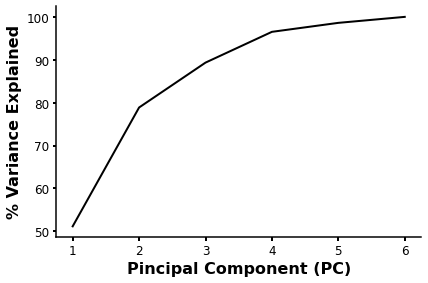

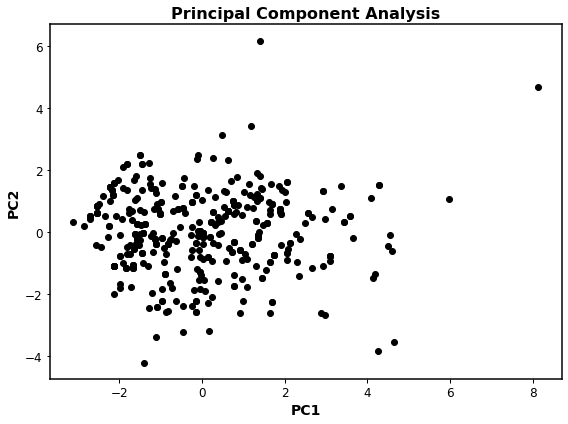

,PC1,PC2,PC3,PC4,PC5,PC6,PC1_normalized,PC2_normalized
0,-1.292014,-2.453941,-2.505376,0.477925,0.832529,0.072638,-0.114812,-0.236015
1,-1.715138,-1.777637,-1.944894,0.246319,0.623260,0.037738,-0.152413,-0.170970
2,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839,-0.190013,-0.105924
3,-1.980135,-0.787001,-1.182908,0.101213,0.370877,-0.003917,-0.175961,-0.075692
4,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839,-0.190013,-0.105924
5,-1.822007,-0.472669,-0.981403,0.187714,0.327762,-0.010672,-0.161909,-0.045460
6,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839,-0.190013,-0.105924
7,-1.980135,-0.787001,-1.182908,0.101213,0.370877,-0.003917,-0.175961,-0.075692
8,-2.245131,0.203635,-0.420921,-0.043892,0.118493,-0.045572,-0.199509,0.019585
9,-2.087003,0.517967,-0.219416,0.042608,0.075379,-0.052327,-0.185458,0.049817
